In [24]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions, Optim, ForwardDiff

In [25]:
include("../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [26]:
using Random

domain = [0, 1]

Random.seed!(123456)

min_separation = 0.05
n_spikes = 15

# Generate points with the required separation
x0 = range(domain[1] + min_separation / 2, domain[2] - min_separation / 2, length=n_spikes)
x0 = x0 .+ (rand(n_spikes) .- 0.5) .* min_separation

a0 = randn(n_spikes)
a0 ./= abs.(a0)

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure([0.04094240182814195, 0.10570419891291588, 0.15631369521567998, 0.24012848046489246, 0.3067210746411662, 0.3522940392930425, 0.43211761705193, 0.5157209316753433, 0.5840789492900793, 0.6271402694900234, 0.7042959333297645, 0.7736100381929988, 0.8217847937222472, 0.9285528451297144, 0.9759940601116013], [1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0], 1, 15)

In [27]:
# Define noise level
noise_level = 0.05

# Seed for noise
# Random.seed!(22)

# Define λ the regularisation parameter, λ ≈ 2 * noise_level
λ = 0.5

0.5

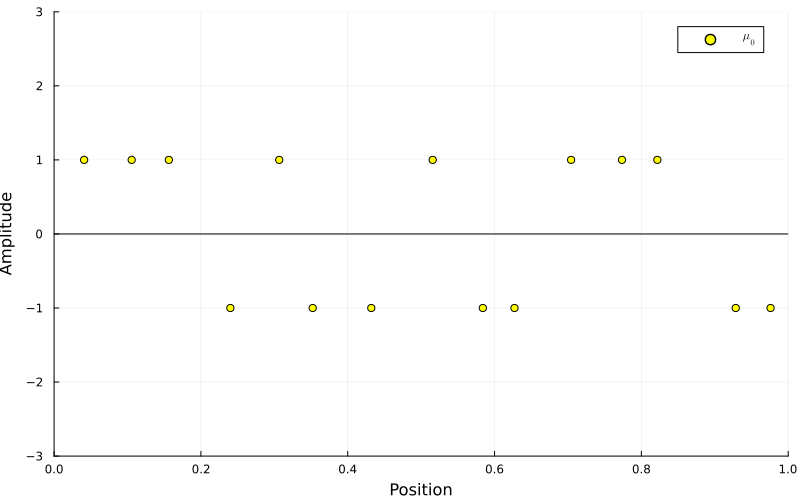

In [28]:
# Define the plot
num_points = 1000
plt_grid = range(domain..., length=(num_points + 1))
plot_size = (400, 250) .* 2
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot_spikes!(plt, μ0, label=L"μ_0", color=:yellow)

In [29]:
ops = gaussian_operators_1D(.005, plt_grid)

Operators(Main.SparseSpikes.var"#ϕ#35"{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Main.SparseSpikes.var"#gauss1DN#34"{Main.SparseSpikes.var"#gauss1D#33"}}(0.005, 0.0:0.001:1.0, Main.SparseSpikes.var"#gauss1DN#34"{Main.SparseSpikes.var"#gauss1D#33"}(Main.SparseSpikes.var"#gauss1D#33"())), Main.SparseSpikes.var"#Φ#37"{Main.SparseSpikes.var"#ϕ#35"{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Main.SparseSpikes.var"#gauss1DN#34"{Main.SparseSpikes.var"#gauss1D#33"}}}(Main.SparseSpikes.var"#ϕ#35"{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Main.SparseSpikes.var"#gauss1DN#34"{Main.SparseSpikes.var"#gauss1D#33"}}(0.005, 0.0:0.001:1.0, Main.SparseSpikes.var"#gauss1DN#34"{Main.SparseSpikes.var"#gauss1D#33"}(Main.SparseSpikes.var"#gauss1D#33"()))), Main.SparseSpikes.var"#adjΦ#38"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base

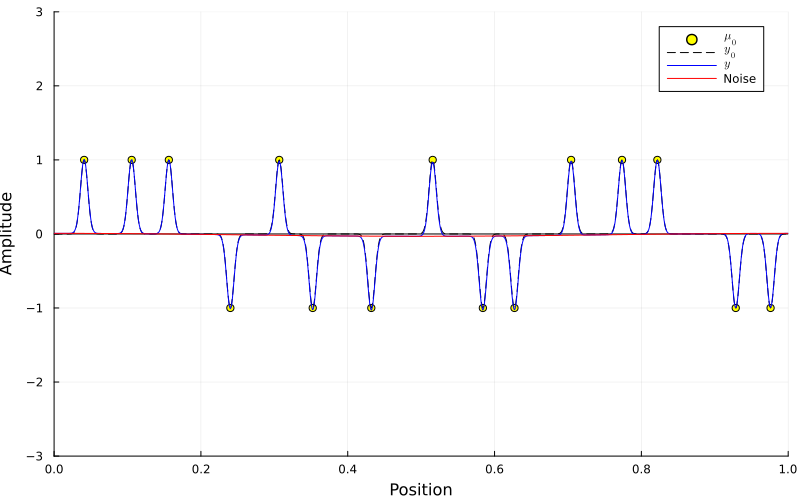

In [30]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(x0, a0)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = randn(length(y0))
cutoff = floor(Int, 0.001 * length(w)) # Low-pass filtering (keep only first 10% of frequencies)
w[cutoff+1:end-cutoff] .= 0  # Zero out high frequencies
w = real(ifft(w))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, y0, label=L"y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, y, label=L"y", color=:blue)
plot!(plt_obs, plt_grid, w, label="Noise", color=:red)


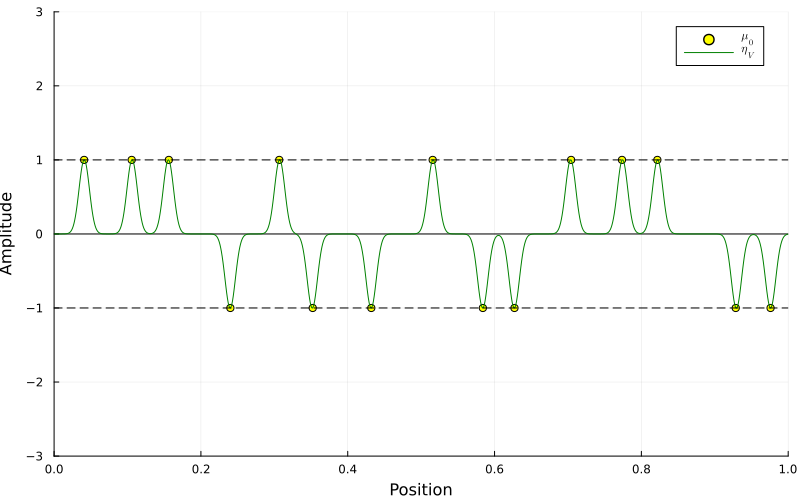

In [31]:
ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηV, label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## Sliding Frank-Wolfe

In [32]:
prob_sfw = BLASSO(y, ops, λ, domain)

BLASSO([0.00801169301266361, 0.008011303921288054, 0.008010136662511335, 0.008008191282472977, 0.008005467858468392, 0.008001966500484977, 0.007997687357141103, 0.007992630637643631, 0.007986796689428935, 0.007980186260685336  …  -0.0030966787661914456, 0.0020268368875520056, 0.0049105314494513495, 0.0064653655311780675, 0.007269181054702991, 0.007668094173535701, 0.00785845485214865, 0.007945995732010916, 0.007984855846105346, 0.008001430876781662], Operators(Main.SparseSpikes.var"#ϕ#35"{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Main.SparseSpikes.var"#gauss1DN#34"{Main.SparseSpikes.var"#gauss1D#33"}}(0.005, 0.0:0.001:1.0, Main.SparseSpikes.var"#gauss1DN#34"{Main.SparseSpikes.var"#gauss1D#33"}(Main.SparseSpikes.var"#gauss1D#33"())), Main.SparseSpikes.var"#Φ#37"{Main.SparseSpikes.var"#ϕ#35"{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Main.SparseSpikes.var"#gauss1DN#34"{Main.Sp

## Original

In [33]:
function SFWO!(blasso::BLASSO, maxits::Int)
    y, λ = blasso.y, blasso.λ
    ϕ, Φ, adjΦ = blasso.operators.ϕ, blasso.operators.Φ, blasso.operators.adjΦ

    η(grid, x, a) = adjΦ(y - Φ(x, a), grid=grid) / λ

    xgrid = range(0, stop=1, length=21)
    M = sum(abs2.(y)) / (2 * λ)
    xvals = Float64[]
    avals = Float64[]

    total_time = 0.0
    compile_time = 0.0

    for k in 1:maxits
        η_k = η(xgrid, xvals, avals)
        idx = argmax(abs.(η_k))
        xnew = xgrid[idx]
        if max(abs.(η_k[idx])) < 1.00001
            break
        end
        mfun(grid) = -0.5norm(η(grid, xvals, avals))^2
        mgrad(grid) = ForwardDiff.gradient(mfun, grid)
        t = @timed result = optimize(mfun, mgrad, [xnew], LBFGS(), inplace=false)
        total_time += t.time
        compile_time += t.compile_time
        xnew = Optim.minimizer(result)[1]
        anew = M .* sign.(η([xnew], xvals, avals))[1]
        append!(xvals, xnew)
        avals *= 1 - 2 / (k + 2)
        append!(avals, 2 / (k + 2) * anew)
        X = adjΦ(ϕ(xvals), grid=xvals)
        Xty = adjΦ(y; grid=xvals)
        τ = 1 / norm(X)
        for _ in 1:100
            avals -= τ * (X * avals .- Xty)
            avals = sign.(avals) .* max.(abs.(avals) .- τ * λ, zeros(length(avals)))
        end

        function func(ax)
            a, x = ax[1:k], ax[(k+1):end]
            0.5λ * sum(abs.(a)) + 0.5norm(y - ϕ(x) * a)^2
        end

        grad = ax -> ForwardDiff.gradient(func, ax)

        ax0 = vcat(avals, xvals)
        a, x = ax0[1:k], ax0[(k+1):end]

        t = @timed result = optimize(func, grad, ax0, BFGS(), inplace=false)
        total_time += t.time
        compile_time += t.compile_time

        avals = Optim.minimizer(result)[1:k]
        xvals = mod.(Optim.minimizer(result)[(k+1):end], 1)
    end

    println("Total time: ", total_time)
    println("Compile time: ", compile_time)
    blasso.μ = DiscreteMeasure(xvals, avals)
end

SFWO! (generic function with 1 method)

In [55]:
SFWO!(prob_sfw, 100)

Total time: 1.7323623000000001
Compile time: 0.0


DiscreteMeasure([0.35231898076129325, 0.7043224332862102, 0.10568087629697911, 0.1563246696258018, 0.306695763036293, 0.04093659868843214, 0.24014542040336137, 0.5840790184632527, 0.4321285079265229], [-1.0048154884681093, 0.9470006036142954, 0.9769979228479918, 0.9706907290255753, 0.9453537603194022, 0.9821797171405994, -0.9865449174580265, -1.0125582239920063, -1.0137292650405287], 1, 9)

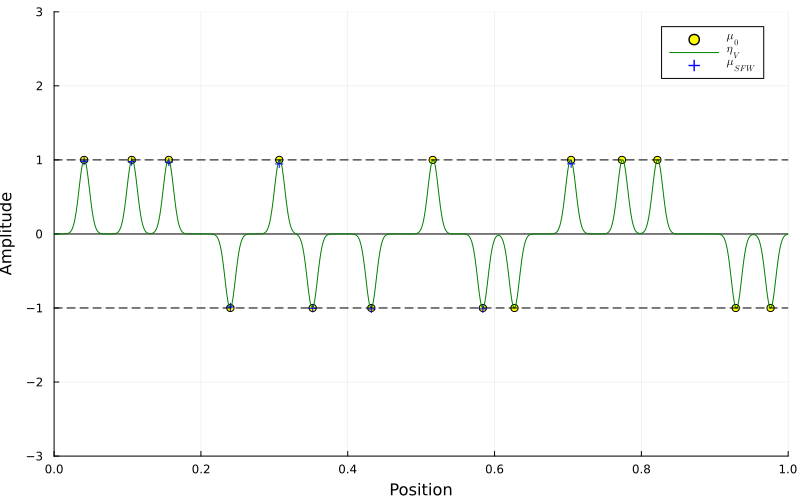

In [56]:
plt_sfw = deepcopy(plt_cert)

plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", color=:blue, marker=:cross)

## Norm(.) instead of sum(abs(.))

In [36]:
function SFWN!(blasso::BLASSO, maxits::Int)
    y, λ = blasso.y, blasso.λ
    ϕ, Φ, adjΦ = blasso.operators.ϕ, blasso.operators.Φ, blasso.operators.adjΦ

    η(grid, x, a) = adjΦ(y - Φ(x, a), grid=grid) / λ

    xgrid = range(0, stop=1, length=21)
    M = sum(abs2.(y)) / (2 * λ)
    xvals = Float64[]
    avals = Float64[]

    total_time = 0.0
    compile_time = 0.0

    for k in 1:maxits
        η_k = η(xgrid, xvals, avals)
        idx = argmax(abs.(η_k))
        xnew = xgrid[idx]
        if max(abs.(η_k[idx])) < 1.00001
            break
        end
        mfun(grid) = -0.5norm(η(grid, xvals, avals))^2
        mgrad(grid) = ForwardDiff.gradient(mfun, grid)
        t = @timed result = optimize(mfun, mgrad, [xnew], LBFGS(), inplace=false)
        total_time += t.time
        compile_time += t.compile_time
        xnew = Optim.minimizer(result)[1]
        anew = M .* sign.(η([xnew], xvals, avals))[1]
        append!(xvals, xnew)
        avals *= 1 - 2 / (k + 2)
        append!(avals, 2 / (k + 2) * anew)
        X = adjΦ(ϕ(xvals), grid=xvals)
        Xty = adjΦ(y; grid=xvals)
        τ = 1 / norm(X)
        for _ in 1:100
            avals -= τ * (X * avals .- Xty)
            avals = sign.(avals) .* max.(abs.(avals) .- τ * λ, zeros(length(avals)))
        end

        function func(ax)
            a, x = ax[1:k], ax[(k+1):end]
            0.5λ * norm(a, 1) + 0.5norm(y - ϕ(x) * a)^2
        end

        grad = ax -> ForwardDiff.gradient(func, ax)

        ax0 = vcat(avals, xvals)
        a, x = ax0[1:k], ax0[(k+1):end]

        t = @timed result = optimize(func, grad, ax0, BFGS(), inplace=false)
        total_time += t.time
        compile_time += t.compile_time

        avals = Optim.minimizer(result)[1:k]
        xvals = mod.(Optim.minimizer(result)[(k+1):end], 1)
    end

    println("Total time: ", total_time)
    println("Compile time: ", compile_time)
    blasso.μ = DiscreteMeasure(xvals, avals)
end

SFWN! (generic function with 1 method)

In [53]:
SFWN!(prob_sfw, 100)

Total time: 1.7274228000000003
Compile time: 0.0


DiscreteMeasure([0.35231898076129325, 0.7043224332862102, 0.10568087629697911, 0.1563246696258018, 0.306695763036293, 0.04093659868843214, 0.24014542040336137, 0.5840790184632527, 0.4321285079265229], [-1.0048154884681093, 0.9470006036142954, 0.9769979228479918, 0.9706907290255753, 0.9453537603194022, 0.9821797171405994, -0.9865449174580265, -1.0125582239920063, -1.0137292650405287], 1, 9)

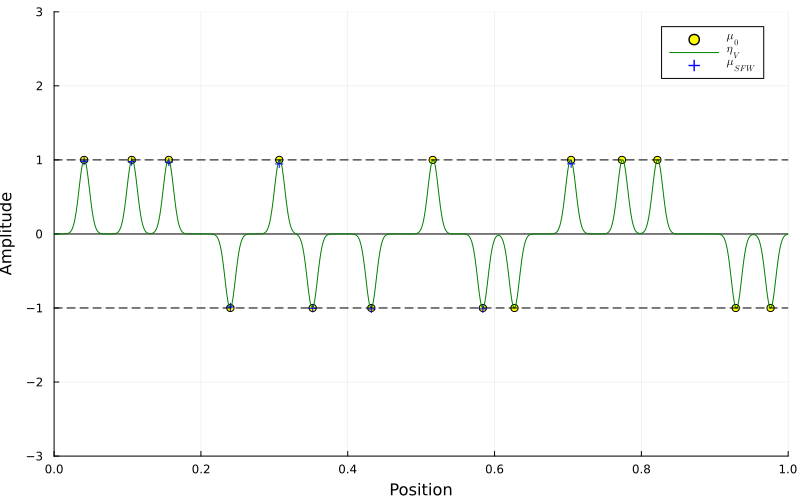

In [54]:
plt_sfw = deepcopy(plt_cert)

plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", color=:blue, marker=:cross)

## Smooth Bilevel

In [39]:
function SFWBL!(blasso::BLASSO, maxits::Int)
    y, λ = blasso.y, blasso.λ
    ϕ, Φ, adjΦ = blasso.operators.ϕ, blasso.operators.Φ, blasso.operators.adjΦ

    η(grid, x, a) = adjΦ(y - Φ(x, a), grid=grid) / λ

    xgrid = range(0, stop=1, length=21)
    M = sum(abs2.(y)) / (2 * λ)
    xvals = Float64[]
    avals = Float64[]

    total_time = 0.0
    compile_time = 0.0

    for k in 1:maxits
        η_k = η(xgrid, xvals, avals)
        idx = argmax(abs.(η_k))
        xnew = xgrid[idx]
        if max(abs.(η_k[idx])) < 1.00001
            break
        end
        mfun(grid) = -0.5norm(η(grid, xvals, avals))^2
        mgrad(grid) = ForwardDiff.gradient(mfun, grid)
        t = @timed result = optimize(mfun, mgrad, [xnew], LBFGS(), inplace=false)
        total_time += t.time
        compile_time += t.compile_time
        xnew = Optim.minimizer(result)[1]
        anew = M .* sign.(η([xnew], xvals, avals))[1]
        append!(xvals, xnew)
        avals *= 1 - 2 / (k + 2)
        append!(avals, 2 / (k + 2) * anew)
        X = adjΦ(ϕ(xvals), grid=xvals)
        Xty = adjΦ(y; grid=xvals)
        τ = 1 / norm(X)
        for _ in 1:100
            avals -= τ * (X * avals .- Xty)
            avals = sign.(avals) .* max.(abs.(avals) .- τ * λ, zeros(length(avals)))
        end
        function func(uvx)
            u, v, x = uvx[1:k], uvx[(k+1):(2k)], uvx[(2k+1):end]
            0.5λ * (norm(u)^2 + norm(v)^2) + 0.5norm(y - ϕ(x) * (u .* v))^2
        end

        grad = uvx -> ForwardDiff.gradient(func, uvx)
        
        u = avals
        v = ones(length(u))

        uvx0 = vcat(u, v, xvals)
        u, v, x = uvx0[1:k], uvx0[(k+1):(2k)], uvx0[(2k+1):end]

        t = @timed result = optimize(func, grad, uvx0, BFGS(), inplace=false)
        total_time += t.time
        compile_time += t.compile_time

        avals = Optim.minimizer(result)[1:k] .* Optim.minimizer(result)[(k+1):(2k)]
        xvals = mod.(Optim.minimizer(result)[(2k+1):end], 1)
    end

    println("Total time: ", total_time)
    println("Compile time: ", compile_time)
    blasso.μ = DiscreteMeasure(xvals, avals)
end

SFWBL! (generic function with 1 method)

In [49]:
SFWBL!(prob_sfw, 100)

Total time: 7.5542836
Compile time: 0.0


DiscreteMeasure([0.3524999999999998, 0.7043428395886816, 0.10566067971344358, 0.04093256768071957, 0.15634520992702816, 0.30667649796027635, 0.2401546596424285, 0.5840840417777805, 0.4321366736334217, 0.35149999999999987], [-0.7883257398148028, 0.9186624229173325, 0.948654401857841, 0.9539648552435681, 0.9423443290686501, 0.9170299978599655, -0.95830690769315, -0.9843398876880413, -0.985496325033378, -0.1871398434447814], 1, 10)

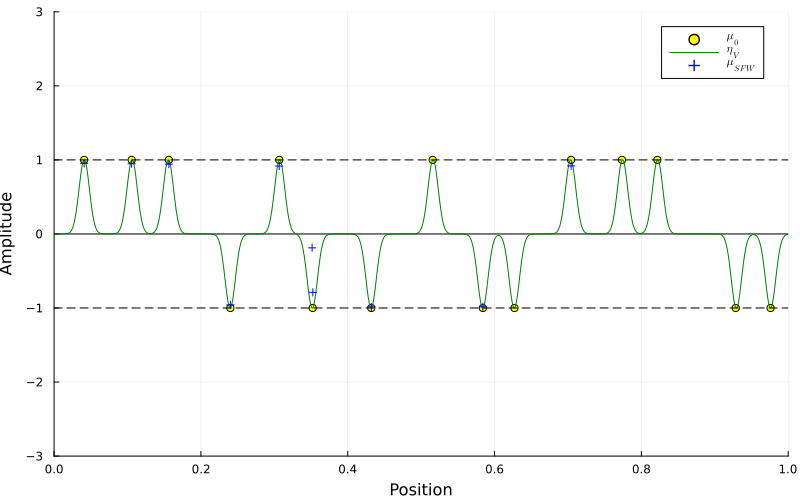

In [50]:
plt_sfw = deepcopy(plt_cert)

plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", color=:blue, marker=:cross)

## Vectors of constant length (properly precompile)

In [42]:
function SFWBL_refactored!(blasso::BLASSO, maxits::Int)
    y, λ = blasso.y, blasso.λ
    ϕ, Φ, adjΦ = blasso.operators.ϕ, blasso.operators.Φ, blasso.operators.adjΦ

    # Define η as before.
    η(grid, x, a) = adjΦ(y - Φ(x, a), grid=grid) / λ

    # Fixed grid and precompute M.
    xgrid = range(0, stop=1, length=21)
    M = sum(abs2, y) / (2 * λ)

    # Preallocate arrays with maximum length.
    xvals = zeros(Float64, maxits)
    avals = zeros(Float64, maxits)
    current_k = 0  # Tracks number of active elements.

    # Define the function for the first (scalar) optimisation step.
    function mfun(x0)
        return -0.5 * norm(η(x0, view(xvals, 1:current_k), view(avals, 1:current_k)))^2
    end
    mgrad = x -> ForwardDiff.gradient(mfun, x)

    # Define the objective for the second optimisation step.
    # ax has fixed length: first maxits for avals, next maxits for xvals.
    function obj(ax)
        a = view(ax, 1:current_k)
        x = view(ax, maxits+1:maxits+current_k)
        return 0.5 * λ * sum(abs.(a)) + 0.5 * norm(y - ϕ(x) * a)^2
    end
    obj_grad = ax -> ForwardDiff.gradient(obj, ax)

    total_time = 0.0
    compile_time = 0.0

    for k in 1:maxits
        if current_k == 0
            xnew = first(xgrid)
        else
            η_vals = η(xgrid, view(xvals, 1:current_k), view(avals, 1:current_k))
            idx = argmax(abs.(η_vals))
            xnew = xgrid[idx]
            if abs(η_vals[idx]) < 1.00001
                break
            end
            # Refine xnew using LBFGS on mfun.
            t = @timed result = optimize(mfun, mgrad, [xnew], LBFGS(), inplace=false)
            total_time += t.time
            compile_time += t.compile_time
            xnew = Optim.minimizer(result)[1]
        end

        # Compute a new coefficient anew.
        anew = M * sign(η([xnew], current_k == 0 ? [] : view(xvals, 1:current_k),
            current_k == 0 ? Float64[] : view(avals, 1:current_k))[1])

        current_k += 1
        xvals[current_k] = xnew
        if current_k > 1
            avals[1:current_k-1] .*= (1 - 2 / (k + 2))
        end
        avals[current_k] = 2 / (k + 2) * anew

        # Proximal gradient step.
        X = adjΦ(ϕ(view(xvals, 1:current_k)), grid=view(xvals, 1:current_k))
        Xty = adjΦ(y, grid=view(xvals, 1:current_k))
        τ = 1 / norm(X)
        for _ in 1:100
            avals[1:current_k] .-= τ * (X * avals[1:current_k] - Xty)
            avals[1:current_k] .= sign.(avals[1:current_k]) .* max.(abs.(avals[1:current_k]) .- τ * λ, zeros(Float64, current_k))
        end

        # Prepare a fixed-size vector for the second optimisation step.
        ax0 = zeros(Float64, 2 * maxits)
        ax0[1:current_k] .= avals[1:current_k]
        ax0[maxits+1:maxits+current_k] .= xvals[1:current_k]
        t = @timed result = optimize(obj, obj_grad, ax0, BFGS(), inplace=false)
        total_time += t.time
        compile_time += t.compile_time

        sol = Optim.minimizer(result)
        avals[1:current_k] .= sol[1:current_k]
        xvals[1:current_k] .= mod.(sol[maxits+1:maxits+current_k], 1)
    end

    println("Total time: $total_time")
    println("Compile time: $compile_time")
    blasso.μ = DiscreteMeasure(xvals[1:current_k], avals[1:current_k])
end

SFWBL_refactored! (generic function with 1 method)

In [47]:
SFWBL_refactored!(prob_sfw, 10)

Total time: 3.1024429999999996
Compile time: 0.0


DiscreteMeasure([0.9759922535658467, 0.3523189807612841, 0.7043224332862097, 0.10568087629699396, 0.15632466962579372, 0.3066957630362903, 0.04093659868843262, 0.24014542040335735, 0.5840790184632524, 0.43212850792652213], [-0.9608168387251275, -1.004815488466547, 0.9470006036145342, 0.976997922848289, 0.9706907290245912, 0.9453537603195288, 0.9821797171411347, -0.9865449174572375, -1.012558223991951, -1.0137292650406], 1, 10)

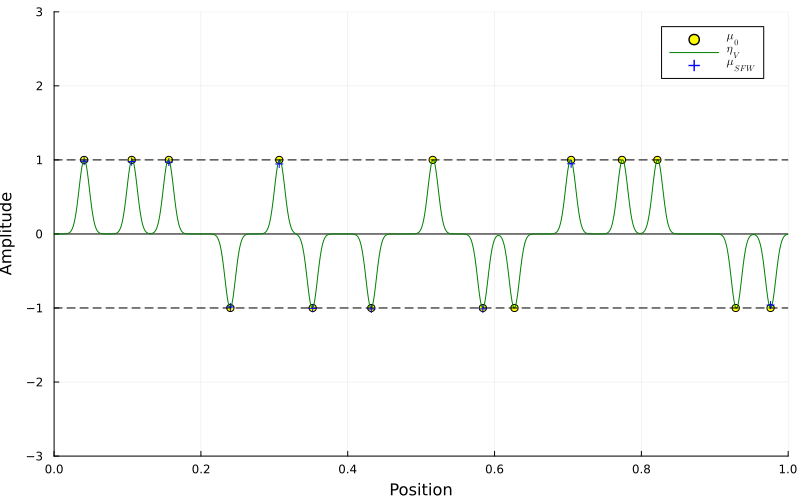

In [48]:
plt_sfw = deepcopy(plt_cert)

plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", color=:blue, marker=:cross)